In [6]:
import pandas_datareader as pdr
import datetime
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pandas_ta as ta
from xmlrpc.client import Boolean

In [5]:
pip install pandas_ta

Defaulting to user installation because normal site-packages is not writeable
  Using cached pandas_ta-0.3.14b.tar.gz (115 kB)
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218923 sha256=a8fcf80e0995353604ec55ec9a15269fe8b87bc69d10718d158c010f16b3c840
  Stored in directory: /Users/haechan/Library/Caches/pip/wheels/1e/5c/47/759b32beb377aee150eb4c1f1b2b7635032cc19ea09ce076fd
Successfully built pandas-ta
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 7.3 MB 6.2 MB/s eta 0:00:01
     |████████████████████████████████| 241 kB 16.0 MB/s eta 0:00:01
     |████████████████████████████████| 965 kB 15.4 MB/s eta 0:00:01
     |████████████████████████████████| 3.1 MB 18.0 MB/s eta 0:00:01     |██████                          | 583 kB 18.0 MB/s eta 0:00:01     |███████████████████████████▋    | 2.7 MB 18.0 MB/s eta 0:00:01
     |████████████████████████████████| 65 kB 4.6 MB/s  eta 0:00:01
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install --upgrade pandas-datareader

Defaulting to user installation because normal site-packages is not writeable
  Using cached pandas_datareader-0.10.0-py3-none-any.whl (109 kB)
  Using cached requests-2.28.1-py3-none-any.whl (62 kB)
     |████████████████████████████████| 12.1 MB 275 kB/s eta 0:00:01
  Using cached lxml-4.9.1-cp39-cp39-macosx_10_15_x86_64.whl (4.6 MB)
     |████████████████████████████████| 500 kB 20.5 MB/s eta 0:00:01
     |████████████████████████████████| 18.1 MB 102 kB/s  eta 0:00:01    |██████████                      | 5.7 MB 23.3 MB/s eta 0:00:01     |███████████████                 | 8.6 MB 23.3 MB/s eta 0:00:01
  Using cached certifi-2022.9.24-py3-none-any.whl (161 kB)
     |████████████████████████████████| 140 kB 4.4 MB/s eta 0:00:01
     |████████████████████████████████| 61 kB 183 kB/s  eta 0:00:01
  Using cached charset_normalizer-2.1.1-py3-none-any.whl (39 kB)
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider a

In [19]:
def macd_strategy(symbol, start, end):
    #get data
    price = pdr.get_data_yahoo(symbol, start, end)
    price = price.drop(['Volume', 'Adj Close'], 1)

    #macd calculations
    exp1 = price.Close.ewm(span = 12, adjust=False).mean()
    exp2 = price.Close.ewm(span = 26, adjust=False).mean()
    macd = exp1 - exp2
    signal = macd.ewm(span = 9, adjust=False).mean()

    #add column for entries
    price['Long'] = macd > signal
    # profit calculation for MACD
    money = 10000
    exchange = 0
    wins= 0
    asset = [10000]
    numb=0
    drawdowns = [0]
    difference = []
    for i in range(1, len(price)):
        
        if price['Long'][i] == True:
            
            if numb==0:
                buy = price['Close'][i]
                numb = money//buy
                money-=numb*buy
            else:
                asset.append(money + (price['Close'][i]*numb))
                drawdowns.append(((money + (price['Close'][i]*numb))-max(asset))/max(asset))
                continue
        else:
           
            if numb!=0 : 
                sell = price['Close'][i]
                money += (sell)*numb
                exchange +=1
                if sell>buy:
                    wins +=1
                difference.append(sell-buy)
                numb=0
            else: 
                
                asset.append(money + (price['Close'][i]*numb))
                drawdowns.append(((money + (price['Close'][i]*numb))-max(asset))/max(asset))
                continue
        
        asset.append(money + (price['Close'][i]*numb))
        drawdowns.append(((money + (price['Close'][i]*numb))-max(asset))/max(asset))
    price['MACD']=asset
    price['DD']=drawdowns

    STARTING_BALANCE = 10000
    #daily return
    price['Return'] = price.Close / price.Close.shift(1)
    price.Return.iat[0] = 1
    price['Bench_Bal'] = STARTING_BALANCE * price.Return.cumprod()
    #calculate drawdown
    price['Bench_Peak'] = price.Bench_Bal.cummax()
    price['Bench_DD'] = price.Bench_Bal - price.Bench_Peak

    bench_dd = round((price.Bench_DD / price.Bench_Peak).min() * 100, 2)
    print("win rate:", wins/exchange)
    print("strategy maximum drawdown", min(price['DD']))
    print("benchmarck maximum drawdwon", bench_dd)
    return price
    
    

In [22]:

def rsi_strategy(symbol, start, end):
    #get data
    price = pdr.get_data_yahoo(symbol, start, end)
    price = price.drop(['Volume', 'Adj Close'], 1)
    rsi = price.ta.rsi(close='Close', length=14, append=True, signal_indicators = True, xa=70, xb=30)
    RSIs=[]
    for i in price['RSI_14_B_30']:
        RSIs.append(Boolean(i))
    RSI= pd.Series(RSIs)
    # profit calculation for RSI
    money = 10000
    exchange = 0
    wins= 0
    drawdowns = [0]
    asset = [10000]
    numb=0
    rsi_index = []
    for i in range(1, len(price)):
        if price['RSI_14_B_30'][i]==1 and numb==0:
            rsi_index.append(i)
            buy = price['Close'][i]
            numb = money//buy
            money-=numb*buy
            asset.append(money + (price['Close'][i]*numb))
            drawdowns.append(((money + (price['Close'][i]*numb))-max(asset))/max(asset))
            continue

        if price['RSI_14_A_70'][i]==1 and numb !=0:
            sell = price['Close'][i]
            money += (sell)*numb
            exchange +=1
            if sell>buy:
                wins +=1
            numb=0
            asset.append(money + (price['Close'][i]*numb))
            drawdowns.append(((money + (price['Close'][i]*numb))-max(asset))/max(asset))
            continue
            
        asset.append(money + (price['Close'][i]*numb))
        drawdowns.append(((money + (price['Close'][i]*numb))-max(asset))/max(asset))

        
    price['RSI_strategy'] = asset
    price['DD']=drawdowns
    print("strategy maximum drawdown", min(price['DD']))
    return price



In [9]:


def bollinger_band_strategy(symbol, start, end):
    def get_sma(prices, rate):
        return prices.rolling(rate).mean()
    price = pdr.DataReader(symbol, 'yahoo', start, end)
    closing_prices = price['Close'] 
    ma = get_sma(closing_prices, 20)
    def get_bollinger_bands(prices, rate=20):
        sma = get_sma(prices, rate)
        std = prices.rolling(rate).std()
        bollinger_up = sma + std * 2 # Calculate top band
        bollinger_down = sma - std * 2 # Calculate bottom band
        return bollinger_up, bollinger_down

    bollinger_up, bollinger_down = get_bollinger_bands(closing_prices)

    # backtrading for bollinger bands
    money = 10000
    exchange = 0
    wins= 0
    asset = [10000]
    numb=0
    bollinger_up, bollinger_down = get_bollinger_bands(price['Close'])

    for i in range(1, len(price)):
        if bollinger_down[i]:
            if price['Close'][i] < bollinger_down[i] and numb==0:
                buy = price['Close'][i]
                numb = money//buy
                money-=numb*buy
            elif price['Close'][i] > bollinger_up[i] and numb!=0:
                sell = price['Close'][i]
                money += (sell)*numb
                exchange +=1
                if sell>buy:
                    wins +=1
                numb=0
            else:
                asset.append(money + (price['Close'][i]*numb))
                continue
        else:
            asset.append(money + (price['Close'][i]*numb))
            continue
        asset.append(money + (price['Close'][i]*numb))

    price['Bollinger'] = asset
    return price



In [10]:
# profit calculation for volatility breakout strategy
def breakout_strategy(symbol, start, end,k):
    price = pdr.get_data_yahoo(symbol, start, end)
    price = price.drop(['Volume', 'Adj Close'], 1)
    money = 10000
    exchange = 0
    wins= 0
    asset = [10000]
    numb=0
    profit=0
    for i in range( len(price)-1):
        volatility = abs(price['High'][i-1]-price['Low'][i-1])
        k=0.3
        if price['High'][i]>price['Open'][i]+(volatility*k):
            buy = price['Open'][i]+(volatility*k)
            numb = money//buy
            sell = price['Close'][i]
            profit = (sell-buy)*numb
            exchange +=1
            if sell>buy:
                wins +=1

        numb=0
        money +=profit
        
        profit=0
        asset.append(money)
    price['breakout'] = asset
    return price



In [11]:
def MACD_BREAKOUT_STRATEGY(symbol, start, end, k):
    #get data
    price = pdr.get_data_yahoo(symbol, start, end)
    price = price.drop(['Volume', 'Adj Close'], 1)

    #macd calculations
    exp1 = price.Close.ewm(span = 12, adjust=False).mean()
    exp2 = price.Close.ewm(span = 26, adjust=False).mean()
    exp3 = price.Close.ewm(span = 26, adjust=False).mean()
    macd = exp1 - exp2
    signal = macd.ewm(span = 9, adjust=False).mean()

    #add column for entries
    price['Long'] = macd > signal
    price['200ema']=exp3
    # profit calculation for MACD
    money = 10000
    exchange = 0
    wins= 0
    asset = [10000]
    numb=0
    difference = []
    for i in range(1, len(price)):
        
        if price['Long'][i] == True:
            
            if numb==0:
                buy = price['Close'][i]
                numb = money//buy
                money-=numb*buy
            else:
                asset.append(money + (price['Close'][i]*numb))
                continue
        elif price['High'][i]>price['Open'][i]+(price['High'][i-1]-price['Low'][i-1] )*k :
            if numb==0:
                buy = price['Open'][i]+(price['High'][i-1]-price['Low'][i-1] )*k
                numb = money//buy
                money-=numb*buy
            else:
                asset.append(money + (price['Close'][i]*numb))
                continue
        else:
           
            if numb!=0 : 
                sell = price['Close'][i]
                money += (sell)*numb
                exchange +=1
                if sell>buy:
                    wins +=1
                difference.append(sell-buy)
                numb=0
            else: 
                
                asset.append(money + (price['Close'][i]*numb))
                continue
        asset.append(money + (price['Close'][i]*numb))
    price['MACD']=asset
    return price

In [21]:
start =datetime.datetime(2021, 1, 1)
end= datetime.datetime(2022, 10, 12)
symbol = 'AAPL'
result_macd= macd_strategy(symbol, start, end)
result_macd

/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_34547/2337481255.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  price = price.drop(['Volume', 'Adj Close'], 1)


win rate: 0.5454545454545454
strategy maximum drawdown -0.17139117429885437
benchmarck maximum drawdwon -28.54


,High,Low,Open,Close,Long,MACD,DD,Return,Bench_Bal,Bench_Peak,Bench_DD
Date,,,,,,,,,,,
2020-12-31,134.740005,131.720001,134.080002,132.690002,False,10000.000000,0.000000,1.000000,10000.000000,10000.000000,0.000000
2021-01-04,133.610001,126.760002,133.520004,129.410004,False,10000.000000,0.000000,0.975281,9752.807392,10000.000000,-247.192608
2021-01-05,131.740005,128.429993,128.889999,131.009995,False,10000.000000,0.000000,1.012364,9873.388507,10000.000000,-126.611493
2021-01-06,131.050003,126.379997,127.720001,126.599998,False,10000.000000,0.000000,0.966338,9541.035206,10000.000000,-458.964794
2021-01-07,131.630005,127.860001,128.360001,130.919998,False,10000.000000,0.000000,1.034123,9866.606056,10000.000000,-133.393944
...,...,...,...,...,...,...,...,...,...,...,...
2022-10-06,147.539993,145.220001,145.809998,145.429993,False,14541.689995,-0.039643,0.993374,10960.131886,13716.933541,-2756.801655
2022-10-07,143.100006,139.449997,142.539993,140.089996,False,14541.689995,-0.039643,0.963281,10557.690388,13716.933541,-3159.243153
2022-10-10,141.889999,138.570007,140.419998,140.419998,False,14541.689995,-0.039643,1.002356,10582.560523,13716.933541,-3134.373018


In [16]:
# here! we combine all the results
start =datetime.datetime(2021, 1, 1)
end= datetime.datetime(2022, 10, 12)
#symbol = 'AAPL'

import random
df = pd.read_csv('constituents_csv.csv')
random_number = random.randint(1,500)
symbol = df['Symbol'][random_number]

# Python3 code to demonstrate working of
# Random K dates in Range
# Using randrange() + timedelta() + loop
from datetime import date, timedelta
import random
  
# initializing dates ranges 
test_date1, test_date2 = date(2011, 1, 1), date(2021, 10, 1)
  
# printing dates 
print("The original range : " + str(test_date1) + " " + str(test_date2))
  
# getting days between dates
dates_bet = test_date2 - test_date1
total_days = dates_bet.days
  
random.seed(a=None)
randay = random.randrange(total_days)
start = test_date1 + timedelta(days=randay)
end = start.replace(start.year + 1)


price = pdr.get_data_yahoo(symbol, start, end)
result_macd= macd_strategy(symbol, start, end)
result_rsi = rsi_strategy(symbol, start, end)
result_bollinger = bollinger_band_strategy(symbol, start,end)
result_breakout = breakout_strategy(symbol, start, end,0.5)
result = MACD_BREAKOUT_STRATEGY(symbol, start, end, 0.5)
print(symbol)
#result_macd_breakout = macd_breakout_strategy(symbol, start, end, 0.3)

The original range : 2011-01-01 2021-10-01


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_34547/3568763280.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  price = price.drop(['Volume', 'Adj Close'], 1)


win rate: 0.5
strategy maximym drawdown -0.12995097107376521
benchmarck maximum drawdwon -24.36


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_34547/1844003133.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  price = price.drop(['Volume', 'Adj Close'], 1)
/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_34547/2752916642.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  price = price.drop(['Volume', 'Adj Close'], 1)


VLO


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_34547/2627110938.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  price = price.drop(['Volume', 'Adj Close'], 1)


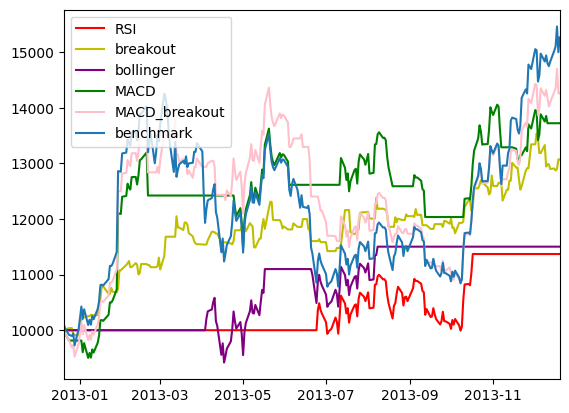

In [18]:
#visualize
plt.plot(result_rsi['RSI_strategy'],c='r', label="RSI")
plt.plot(result_breakout['breakout'],c='y', label = "breakout")
plt.plot(result_bollinger['Bollinger'], c = 'purple', label = "bollinger")
plt.plot(result_macd['MACD'],c='g', label = 'MACD')
plt.plot(result['MACD'], c='pink', label = 'MACD_breakout')
plt.plot(result_rsi['Close']*(10000/result_rsi['Close'][0]), label = "benchmark")
plt.xlim(start,end)
plt.legend()
plt.show()